In [55]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

In [57]:
data_dir = '/USER/data002'

In [58]:
df = pd.read_csv(os.path.join(data_dir,'dataset002.csv'))

In [59]:
df_col = df.columns.values

## Data Preprocessing

In [60]:
class StandardScaler() :
    def __init__(self) :
        self.mean_lst = []
        self.std_lst = []
        
    def fit(self, df) :
        self.df_col = df.columns.values
        for i in range(len(self.df_col[2:])) :
            mean = df[self.df_col[i+2]].mean()
            std = df[self.df_col[i+2]].std()
            
            self.mean_lst.append(mean)
            self.std_lst.append(std)
        
    def scale(self, df) :
        for i in range(len(self.df_col[2:])) :
            mean = self.mean_lst[i]
            std = self.std_lst[i]
            df[self.df_col[i+2]] = (df[self.df_col[i+2]]-mean)/std
            
        return df
    
    def unscale(self, df) :
        for i in range(len(self.df_col[2:])) :
            mean = self.mean_lst[i]
            std = self.std_lst[i]
            df[self.df_col[i+2]] = df[self.df_col[i+2]]*std + mean
            
        return df

In [61]:
scaler = StandardScaler()
scaler.fit(df)

In [62]:
class CustomDataset(Dataset) :
    def __init__(self, data_dir, mode, backcast, forecast, scaler) :
        self.mode = mode
        self.backcast = backcast * 24
        self.forecast = forecast * 24
        
        df_path = os.path.join(data_dir, 'dataset002.csv')
        df = pd.read_csv(df_path)
        df_col = df.columns.values
        df = scaler.scale(df)
        
        if self.mode == 'train' :
            self.df = df[df_col[2:]].iloc[:-self.forecast].values
                
        elif self.mode == 'valid' :
            self.df = df[df_col[2:]].iloc[-(self.backcast+self.forecast):].values
        
        elif self.mode == 'test' :
            self.df = df[df_col[2:]].iloc[-self.backcast:].values

    def __getitem__(self, index) :
        x_end = int(index*24 + self.backcast)
        y_end = int(x_end + self.forecast)
        
        if self.mode == 'test' :
            x = torch.FloatTensor(self.df[index*24:x_end])
            return x

        x = torch.FloatTensor(self.df[index*24:x_end])
        label = torch.FloatTensor(self.df[x_end:y_end])

        return x, label
    
    def __len__(self) :
        return int(len(self.df)/24 - (self.backcast + self.forecast)/24) + 1

In [222]:
class NBeats(nn.Module):
    def __init__(self,
                 backcast,
                 forecast,
                 theta_dim=(2, 14, 4),
                 n_trend=2,
                 n_seasonality=2,
                 n_residual=2,
                 hidden_dim=512,
                 feature_dim=35):
        super(NBeats, self).__init__()
        self.backcast = backcast * 24
        self.forecast = forecast * 24
        
        self.trend_stack = []
        self.seasonality_stack = []
        self.residual_stack = [] #bs =[] 이건했는데 fs=[] 이거 안해줌
        
        for i in range(n_trend):
            self.trend_stack.append(Block(self.backcast, self.forecast, hidden_dim, theta_dim[0], mode='trend', feature_dim=feature_dim))    

        for i in range(n_seasonality):
            self.seasonality_stack.append(Block(self.backcast, self.forecast, hidden_dim, theta_dim[1], mode='seasonality', feature_dim=feature_dim))
        
        for i in range(n_residual):
            self.residual_stack.append(Block(self.backcast, self.forecast, hidden_dim, theta_dim[2], mode='residual', feature_dim=feature_dim))
        
        
        self.trend_stack = nn.ModuleList(self.trend_stack)
        self.seasonality_stack = nn.ModuleList(self.seasonality_stack)
        self.residual_stack = nn.ModuleList(self.residual_stack)

    def forward(self, x):
        backcast_stack = []
        forecast_stack = []

        for layer in self.trend_stack:
            b, f = layer(x)
            backcast_stack.append(b)
            forecast_stack.append(f)
            x = x - b

        for layer in self.seasonality_stack:
            b, f = layer(x)
            backcast_stack.append(b)
            forecast_stack.append(f)
            x = x - b


        for layer in self.residual_stack:
            b, f = layer(x)
            backcast_stack.append(b)
            forecast_stack.append(f)
            x = x - b

        backcast = torch.stack(backcast_stack, 0)
        forecast = torch.stack(forecast_stack, 0)
        return backcast, forecast


# ours
class Block(nn.Module):
    def __init__(self, backcast, forecast, hidden_dim, theta_dim, mode, feature_dim):
        super(Block, self).__init__()
        self.backcast = backcast
        self.forecast = forecast
        self.theta_dim = theta_dim
        self.mode = mode

        self.MLP = nn.Sequential(
                nn.Linear(backcast * feature_dim, hidden_dim), 
                nn.ReLU(),
                nn.Linear(hidden_dim, 2*hidden_dim),
                nn.ReLU(),
                nn.Linear(2*hidden_dim, 2*hidden_dim),
                nn.ReLU(),
                nn.Linear(2*hidden_dim, hidden_dim),
                nn.ReLU()
            ) # univariate??multivariate??

        if mode == 'residual':
            # residual  
            self.theta_b = nn.Linear(hidden_dim, theta_dim * feature_dim)             
            self.theta_f = nn.Linear(hidden_dim, theta_dim * feature_dim)
            self.linear_b = nn.Linear(theta_dim, backcast)
            self.linear_f = nn.Linear(theta_dim, forecast)
        else:
            # trend, seasonality
            self.theta = nn.Linear(hidden_dim, theta_dim*feature_dim)


    def forward(self, x):
        shape = x.shape
        # x: (batch size, backcast length, feature_dim)
        t_b = ((torch.arange(start=0, end=self.backcast, device=x.device, dtype=torch.float) - self.backcast) / 24 ) # (backcast_len,)
        t_f = ((torch.arange(start=0, end=self.forecast, device=x.device, dtype=torch.float)) / 24 ) # (forecast_len,)

        # x -> h
        x = self.MLP(x.reshape(x.shape[0], -1)) # (batch, backcast length * feature_dim) -> (batch, theta_dim)

        # h -> theta -> backcast, forecast
        if self.mode == 'residual':
            # residual block
            theta_b = self.theta_b(x).reshape(shape[0], shape[2], self.theta_dim)
            theta_f = self.theta_f(x).reshape(shape[0], shape[2], self.theta_dim)
            b = self.linear_b(theta_b).permute(0,2,1) # (batch, backcast length, feature_dim)
            f = self.linear_f(theta_f).permute(0,2,1) # (batch, forecast length, feature_dim)
        else:
            theta_b = self.theta(x).reshape(shape[0], self.theta_dim, shape[2])
            theta_f = theta_b

            if self.mode == 'trend':
                b = self.get_trend(theta_b, t_b)
                f = self.get_trend(theta_f, t_f)
                
            elif self.mode == 'seasonality':
                b = self.get_seasonality(theta_b, t_b)
                f = self.get_seasonality(theta_f, t_f)
        return b, f

    def get_trend(self, theta, t):
        # theta dim = 0 -> 수평선 (y=a)
        # theta dim = 1 -> 직선 (y=bx)
        # theta dim = 2 -> 이차곡선 (y=cx^2)
        # ...
        T = torch.stack([t ** i for i in range(theta.shape[1])])  # (theta_dim ,sequence length)
        out = torch.einsum('btf,ts->bsf', theta, T)
        return out


    def get_seasonality(self, theta, t):
        s1 = torch.stack([torch.cos(2 * np.pi * (i+1) * t) for i in range(self.theta_dim//2)]).float()  # H/2-1
        s2 = torch.stack([torch.sin(2 * np.pi * (i+1) * t) for i in range(self.theta_dim//2)]).float()
        S = torch.cat([s1, s2])
        out = torch.einsum('btf,ts->bsf', theta, S)
        return out

In [223]:
# 결과 파일과 모델 가중치 파일 저장을 위해 log 디렉토리 생성. 중요한 파일이 덮어씌워지지 않도록 주의
os.makedirs('log', exist_ok=True)      # log 폴더 생성, 이미 생성되었을 시 추가로 생성하지 않도록 exist_ok=True


def save_model(model_name, model, optimizer):      # 모델 가중치 파일 저장 함수
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
        # 'scheduler' : scheduler.state_dict()
    }
    torch.save(state, os.path.join('log', model_name + '.pt'))
    print('model saved\n')


def load_model(model_name, model, optimizer=None):      # 모델 가중치 파일 로드 함수
    state = torch.load(os.path.join('log',model_name))
    model.load_state_dict(state['model'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optimizer'])
    print('model loaded')

In [224]:
dtype = torch.float
num_epochs = 100
learning_rate = 1e-4*5
backcast = 7
forecast = 7

feature_dim = 35
hidden_dim = 1024
batch_size = 125

In [181]:
train_dataset = CustomDataset(data_dir=data_dir, mode='train', backcast=backcast, forecast=forecast, scaler=scaler)
valid_dataset = CustomDataset(data_dir=data_dir, mode='valid', backcast=backcast, forecast=forecast, scaler=scaler)

In [182]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [183]:
for input_data, output_data in train_dataloader :
    print(input_data.shape, output_data.shape)

torch.Size([125, 168, 35]) torch.Size([125, 168, 35])


In [225]:
model = NBeats(forecast=forecast, backcast=backcast, hidden_dim=hidden_dim, feature_dim=feature_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler =  torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=1e-5, epochs=num_epochs, steps_per_epoch=len(train_dataloader))

In [53]:
print(model)

NBeats(
  (trend_stack): ModuleList(
    (0): Block(
      (MLP): Sequential(
        (0): Linear(in_features=17640, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=2048, bias=True)
        (3): ReLU()
        (4): Linear(in_features=2048, out_features=2048, bias=True)
        (5): ReLU()
        (6): Linear(in_features=2048, out_features=1024, bias=True)
        (7): ReLU()
      )
      (theta): Linear(in_features=1024, out_features=70, bias=True)
    )
    (1): Block(
      (MLP): Sequential(
        (0): Linear(in_features=17640, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=2048, bias=True)
        (3): ReLU()
        (4): Linear(in_features=2048, out_features=2048, bias=True)
        (5): ReLU()
        (6): Linear(in_features=2048, out_features=1024, bias=True)
        (7): ReLU()
      )
      (theta): Linear(in_features=1024, out_features=70, bias=True)
    )
    (2): Bl

In [226]:
train_batch_loss = []
train_epoch_loss = []

valid_epoch_loss = []
valid_min_epoch_loss = np.inf
for epoch in tqdm(range(num_epochs)) :
    model.train()

    for i, sample in enumerate(train_dataloader) :

        input_data, output_data = sample

        input_data = input_data.to(device)
        output_data = output_data.to(device)

        pred_backcast, pred_forecast = model(input_data)
        loss = criterion(pred_backcast.sum(0), input_data) + criterion(pred_forecast.sum(0), output_data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        train_batch_loss.append(loss.item())
        train_epoch_loss.append(loss.item())

        if i % 400 == 399:      # 400개의 batch마다 training Loss 출력
            print('Train Epoch: {:2} | Batch: {:4} | Loss: {:1.2f}'.format(epoch+1, i+1, np.array(train_batch_loss).mean()))
            train_batch_loss = []

    print(f'Train Epoch_Loss: {np.array(train_epoch_loss).mean()}')
    train_epoch_loss = []

    model.eval()      # 모델을 eval mode로 전환. eval mode에서 적용되면 안되는 drop out 등이 적용되지 않게 하기 위함

    with torch.no_grad():      # validation / test set에 대해서는 weight 및 bias의 update, 즉, gradient descent가 일어나지 않도록 no_grad()를 선언

        for i, sample in enumerate(valid_dataloader):      # enumerate 함수를 통해 validate_dataloader에서 'batch의 index'와 'batch'를 순서대로 호출

            input_data, output_data = sample      # validate_dataloader에서 불러온 sample은 [[날짜, 시간], [도로], [[input_data],[output_data]]]로 구성됨. validation에는 [[input_data], [output_data]]만 사용

            input_data = input_data.to(device)
            output_data = output_data.to(device)

            pred_backcast, pred_forecast = model(input_data)
            loss = criterion(pred_backcast.sum(0), input_data) + criterion(pred_forecast.sum(0), output_data)
            valid_epoch_loss.append(loss.item())

        print('\nValid Epoch: {:2} | Loss: {:1.2f}'.format(epoch+1, np.array(valid_epoch_loss).mean()))

        if np.array(valid_epoch_loss).mean() < valid_min_epoch_loss:
            save_model('NBeats_v201', model, optimizer)
            valid_min_epoch_loss = np.array(valid_epoch_loss).mean()

        valid_epoch_loss = []

  0% 0/100 [00:00<?, ?it/s]

Train Epoch_Loss: 2.640876054763794

Valid Epoch:  1 | Loss: 42.29


  1% 1/100 [00:01<02:07,  1.28s/it]

model saved

Train Epoch_Loss: 39.83734130859375

Valid Epoch:  2 | Loss: 1.53


  2% 2/100 [00:07<04:21,  2.67s/it]

model saved

Train Epoch_Loss: 1.5932819843292236

Valid Epoch:  3 | Loss: 1.53


  3% 3/100 [00:13<05:56,  3.67s/it]

model saved

Train Epoch_Loss: 1.60386061668396

Valid Epoch:  4 | Loss: 1.20


  4% 4/100 [00:19<06:57,  4.35s/it]

model saved

Train Epoch_Loss: 1.26820707321167

Valid Epoch:  5 | Loss: 1.12


  5% 5/100 [00:25<07:41,  4.86s/it]

model saved

Train Epoch_Loss: 1.2315115928649902

Valid Epoch:  6 | Loss: 1.01


  6% 6/100 [00:31<08:09,  5.20s/it]

model saved

Train Epoch_Loss: 1.0997540950775146

Valid Epoch:  7 | Loss: 0.98


  7% 7/100 [00:37<08:27,  5.46s/it]

model saved

Train Epoch_Loss: 1.0485472679138184

Valid Epoch:  8 | Loss: 0.93


  8% 8/100 [00:43<08:37,  5.62s/it]

model saved

Train Epoch_Loss: 1.0028244256973267

Valid Epoch:  9 | Loss: 0.89


  9% 9/100 [00:49<08:42,  5.74s/it]

model saved

Train Epoch_Loss: 0.9602672457695007

Valid Epoch: 10 | Loss: 0.87


 10% 10/100 [00:55<08:48,  5.87s/it]

model saved

Train Epoch_Loss: 0.9407800436019897

Valid Epoch: 11 | Loss: 0.85


 11% 11/100 [01:01<08:45,  5.90s/it]

model saved

Train Epoch_Loss: 0.9233849048614502

Valid Epoch: 12 | Loss: 0.84


 12% 12/100 [01:07<08:41,  5.92s/it]

model saved

Train Epoch_Loss: 0.902523398399353

Valid Epoch: 13 | Loss: 0.82


 15% 15/100 [01:13<05:55,  4.19s/it]

model saved

Train Epoch_Loss: 0.8957483768463135

Valid Epoch: 14 | Loss: 0.88
Train Epoch_Loss: 0.9221497774124146

Valid Epoch: 15 | Loss: 0.85


 19% 19/100 [01:13<02:49,  2.09s/it]

Train Epoch_Loss: 0.9333391189575195

Valid Epoch: 16 | Loss: 0.84
Train Epoch_Loss: 0.9269090890884399

Valid Epoch: 17 | Loss: 0.83
Train Epoch_Loss: 0.891482949256897

Valid Epoch: 18 | Loss: 0.84
Train Epoch_Loss: 0.8992139101028442

Valid Epoch: 19 | Loss: 0.83
Train Epoch_Loss: 0.8909158706665039

Valid Epoch: 20 | Loss: 0.80


 20% 20/100 [01:19<04:18,  3.23s/it]

model saved

Train Epoch_Loss: 0.869759738445282

Valid Epoch: 21 | Loss: 0.80


 21% 21/100 [01:25<05:19,  4.04s/it]

model saved

Train Epoch_Loss: 0.8595576286315918

Valid Epoch: 22 | Loss: 0.80


 22% 22/100 [01:31<05:59,  4.61s/it]

model saved

Train Epoch_Loss: 0.8539563417434692

Valid Epoch: 23 | Loss: 0.79


 23% 23/100 [01:37<06:24,  5.00s/it]

model saved

Train Epoch_Loss: 0.8462937474250793

Valid Epoch: 24 | Loss: 0.78


 24% 24/100 [01:43<06:41,  5.28s/it]

model saved

Train Epoch_Loss: 0.8386434316635132

Valid Epoch: 25 | Loss: 0.77


 25% 25/100 [01:49<06:50,  5.48s/it]

model saved

Train Epoch_Loss: 0.8297635316848755

Valid Epoch: 26 | Loss: 0.77


 26% 26/100 [01:55<06:56,  5.62s/it]

model saved

Train Epoch_Loss: 0.8254443407058716

Valid Epoch: 27 | Loss: 0.77


 27% 27/100 [02:01<06:56,  5.71s/it]

model saved

Train Epoch_Loss: 0.8202582597732544

Valid Epoch: 28 | Loss: 0.76


 28% 28/100 [02:07<06:55,  5.78s/it]

model saved

Train Epoch_Loss: 0.812718391418457

Valid Epoch: 29 | Loss: 0.76


 29% 29/100 [02:13<06:53,  5.82s/it]

model saved

Train Epoch_Loss: 0.8058741688728333

Valid Epoch: 30 | Loss: 0.76


 30% 30/100 [02:18<06:48,  5.84s/it]

model saved

Train Epoch_Loss: 0.8010563850402832

Valid Epoch: 31 | Loss: 0.75


 31% 31/100 [02:24<06:45,  5.88s/it]

model saved

Train Epoch_Loss: 0.7947771549224854

Valid Epoch: 32 | Loss: 0.75


 32% 32/100 [02:30<06:41,  5.90s/it]

model saved

Train Epoch_Loss: 0.7892794609069824

Valid Epoch: 33 | Loss: 0.74


 33% 33/100 [02:36<06:36,  5.91s/it]

model saved

Train Epoch_Loss: 0.784212052822113

Valid Epoch: 34 | Loss: 0.74


 34% 34/100 [02:43<06:35,  5.99s/it]

model saved

Train Epoch_Loss: 0.7784144878387451

Valid Epoch: 35 | Loss: 0.74
Train Epoch_Loss: 0.7739505767822266

Valid Epoch: 36 | Loss: 0.74


 36% 36/100 [02:49<05:26,  5.11s/it]

model saved

Train Epoch_Loss: 0.7694764137268066

Valid Epoch: 37 | Loss: 0.74
Train Epoch_Loss: 0.766296923160553

Valid Epoch: 38 | Loss: 0.73


 40% 40/100 [02:55<03:09,  3.16s/it]

model saved

Train Epoch_Loss: 0.7774080038070679

Valid Epoch: 39 | Loss: 0.77
Train Epoch_Loss: 0.8088979125022888

Valid Epoch: 40 | Loss: 0.74
Train Epoch_Loss: 0.7734060883522034

Valid Epoch: 41 | Loss: 0.74
Train Epoch_Loss: 0.7834725379943848

Valid Epoch: 42 | Loss: 0.73


 42% 42/100 [03:01<03:00,  3.12s/it]

model saved

Train Epoch_Loss: 0.7595241069793701

Valid Epoch: 43 | Loss: 0.72


 43% 43/100 [03:07<03:46,  3.97s/it]

model saved

Train Epoch_Loss: 0.7578426599502563

Valid Epoch: 44 | Loss: 0.72


 46% 46/100 [03:13<02:54,  3.23s/it]

model saved

Train Epoch_Loss: 0.7611141204833984

Valid Epoch: 45 | Loss: 0.72
Train Epoch_Loss: 0.7555155158042908

Valid Epoch: 46 | Loss: 0.73
Train Epoch_Loss: 0.7477867603302002

Valid Epoch: 47 | Loss: 0.73
Train Epoch_Loss: 0.7434782981872559

Valid Epoch: 48 | Loss: 0.72


 48% 48/100 [03:19<02:44,  3.17s/it]

model saved

Train Epoch_Loss: 0.7422662973403931

Valid Epoch: 49 | Loss: 0.71


 49% 49/100 [03:25<03:24,  4.01s/it]

model saved

Train Epoch_Loss: 0.7376459836959839

Valid Epoch: 50 | Loss: 0.71


 50% 50/100 [03:31<03:50,  4.60s/it]

model saved

Train Epoch_Loss: 0.7319492101669312

Valid Epoch: 51 | Loss: 0.71


 51% 51/100 [03:37<04:05,  5.01s/it]

model saved

Train Epoch_Loss: 0.7282971143722534

Valid Epoch: 52 | Loss: 0.70


 52% 52/100 [03:43<04:14,  5.30s/it]

model saved

Train Epoch_Loss: 0.7249725461006165

Valid Epoch: 53 | Loss: 0.70


 53% 53/100 [03:49<04:18,  5.49s/it]

model saved

Train Epoch_Loss: 0.7207831144332886

Valid Epoch: 54 | Loss: 0.70


 54% 54/100 [03:55<04:19,  5.65s/it]

model saved

Train Epoch_Loss: 0.7180125713348389

Valid Epoch: 55 | Loss: 0.70


 57% 57/100 [04:01<02:54,  4.05s/it]

model saved

Train Epoch_Loss: 0.7154552340507507

Valid Epoch: 56 | Loss: 0.70
Train Epoch_Loss: 0.7129336595535278

Valid Epoch: 57 | Loss: 0.70


 59% 59/100 [04:01<01:57,  2.86s/it]

Train Epoch_Loss: 0.7110627293586731

Valid Epoch: 58 | Loss: 0.70
Train Epoch_Loss: 0.709280788898468

Valid Epoch: 59 | Loss: 0.70
Train Epoch_Loss: 0.709505558013916

Valid Epoch: 60 | Loss: 0.69


 62% 62/100 [04:07<01:41,  2.67s/it]

model saved

Train Epoch_Loss: 0.7015491724014282

Valid Epoch: 61 | Loss: 0.71
Train Epoch_Loss: 0.703046441078186

Valid Epoch: 62 | Loss: 0.70
Train Epoch_Loss: 0.6985708475112915

Valid Epoch: 63 | Loss: 0.70
Train Epoch_Loss: 0.6973927021026611

Valid Epoch: 64 | Loss: 0.69


 66% 66/100 [04:13<01:06,  1.97s/it]

model saved

Train Epoch_Loss: 0.6918758749961853

Valid Epoch: 65 | Loss: 0.70
Train Epoch_Loss: 0.6912920475006104

Valid Epoch: 66 | Loss: 0.70
Train Epoch_Loss: 0.688155472278595

Valid Epoch: 67 | Loss: 0.69


 69% 69/100 [04:20<01:09,  2.25s/it]

model saved

Train Epoch_Loss: 0.6850055456161499

Valid Epoch: 68 | Loss: 0.69
Train Epoch_Loss: 0.6828323006629944

Valid Epoch: 69 | Loss: 0.69


 71% 71/100 [04:20<00:46,  1.60s/it]

Train Epoch_Loss: 0.6802302598953247

Valid Epoch: 70 | Loss: 0.69
Train Epoch_Loss: 0.6773934960365295

Valid Epoch: 71 | Loss: 0.70
Train Epoch_Loss: 0.6752526760101318

Valid Epoch: 72 | Loss: 0.70


 75% 75/100 [04:20<00:20,  1.22it/s]

Train Epoch_Loss: 0.6725610494613647

Valid Epoch: 73 | Loss: 0.69
Train Epoch_Loss: 0.670134425163269

Valid Epoch: 74 | Loss: 0.70
Train Epoch_Loss: 0.667826235294342

Valid Epoch: 75 | Loss: 0.70
Train Epoch_Loss: 0.6652778387069702

Valid Epoch: 76 | Loss: 0.70


 77% 77/100 [04:20<00:13,  1.69it/s]

Train Epoch_Loss: 0.662943959236145

Valid Epoch: 77 | Loss: 0.70
Train Epoch_Loss: 0.6606891751289368

Valid Epoch: 78 | Loss: 0.69
Train Epoch_Loss: 0.6582192182540894

Valid Epoch: 79 | Loss: 0.69


 81% 81/100 [04:26<00:18,  1.05it/s]

model saved

Train Epoch_Loss: 0.6558290123939514

Valid Epoch: 80 | Loss: 0.69
Train Epoch_Loss: 0.6535543203353882

Valid Epoch: 81 | Loss: 0.69
Train Epoch_Loss: 0.6511257886886597

Valid Epoch: 82 | Loss: 0.70
Train Epoch_Loss: 0.6490169763565063

Valid Epoch: 83 | Loss: 0.69


 83% 83/100 [04:32<00:26,  1.57s/it]

model saved

Train Epoch_Loss: 0.6467539072036743

Valid Epoch: 84 | Loss: 0.70
Train Epoch_Loss: 0.6446777582168579

Valid Epoch: 85 | Loss: 0.68


 85% 85/100 [04:39<00:30,  2.04s/it]

model saved

Train Epoch_Loss: 0.642931342124939

Valid Epoch: 86 | Loss: 0.70
Train Epoch_Loss: 0.6413897275924683

Valid Epoch: 87 | Loss: 0.67


 89% 89/100 [04:45<00:18,  1.66s/it]

model saved

Train Epoch_Loss: 0.6404725313186646

Valid Epoch: 88 | Loss: 0.71
Train Epoch_Loss: 0.6381715536117554

Valid Epoch: 89 | Loss: 0.67


 91% 91/100 [04:45<00:10,  1.19s/it]

Train Epoch_Loss: 0.634692907333374

Valid Epoch: 90 | Loss: 0.68
Train Epoch_Loss: 0.6311819553375244

Valid Epoch: 91 | Loss: 0.70
Train Epoch_Loss: 0.6298223733901978

Valid Epoch: 92 | Loss: 0.67


 94% 94/100 [04:51<00:11,  1.86s/it]

model saved

Train Epoch_Loss: 0.6289509534835815

Valid Epoch: 93 | Loss: 0.70
Train Epoch_Loss: 0.6257867217063904

Valid Epoch: 94 | Loss: 0.68


 96% 96/100 [04:51<00:05,  1.33s/it]

Train Epoch_Loss: 0.6225019693374634

Valid Epoch: 95 | Loss: 0.68
Train Epoch_Loss: 0.6207690238952637

Valid Epoch: 96 | Loss: 0.70
Train Epoch_Loss: 0.6194446086883545

Valid Epoch: 97 | Loss: 0.67


100% 100/100 [04:52<00:00,  2.92s/it]

Train Epoch_Loss: 0.6174209117889404

Valid Epoch: 98 | Loss: 0.70
Train Epoch_Loss: 0.6143559217453003

Valid Epoch: 99 | Loss: 0.69
Train Epoch_Loss: 0.6119036078453064

Valid Epoch: 100 | Loss: 0.67


In [227]:
model_path = 'NBeats_v201.pt'

In [228]:
model = NBeats(backcast=backcast, forecast=forecast, hidden_dim=hidden_dim).to(device)

In [229]:
state = torch.load(os.path.join('log',model_path))
model.load_state_dict(state['model'])

<All keys matched successfully>

In [230]:
test_dataset = CustomDataset(data_dir=data_dir, mode='test', backcast=backcast, forecast=0, scaler=scaler)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [231]:
pred_lst = []

model.eval()
with torch.no_grad():
    for sample in test_dataloader :
        input_data = sample.to(device)
        pred_backcast, pred_forecast = model(input_data)
        pred_lst.append(pred_forecast.sum(0).squeeze(0).squeeze(0).cpu().numpy())

In [232]:
test_set = pd.DataFrame(columns=['날짜','시간'])

In [233]:
day = []
time = []
for i in range(168) :
    day.append(20200525+i//24)
    time.append(i%24)

In [234]:
test_set['날짜']=day
test_set['시간']=time

In [235]:
for i in range(35) :
    test_set[df_col[i+2]] = pred_lst[0][:,i]

In [236]:
test_set = scaler.unscale(test_set)

In [237]:
df_test = pd.concat([df,test_set]).reset_index(drop=True)

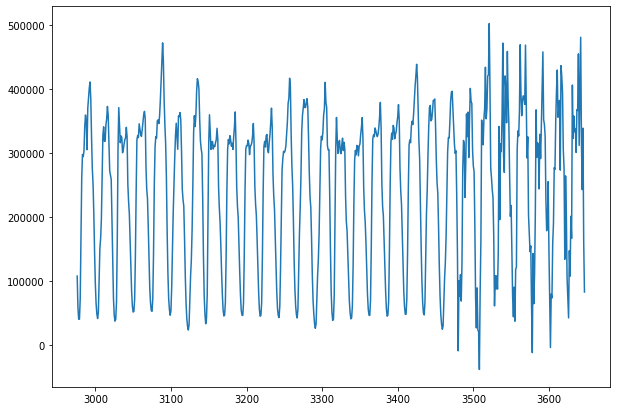

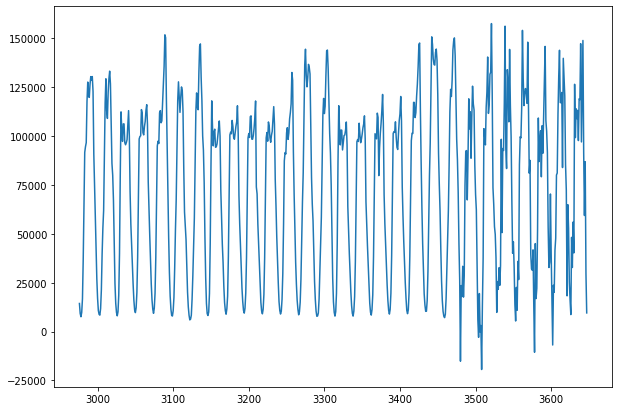

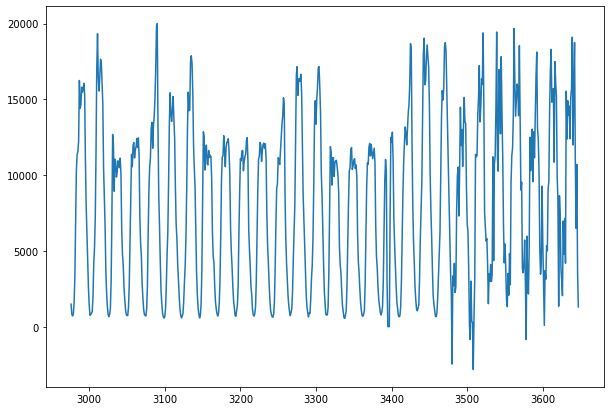

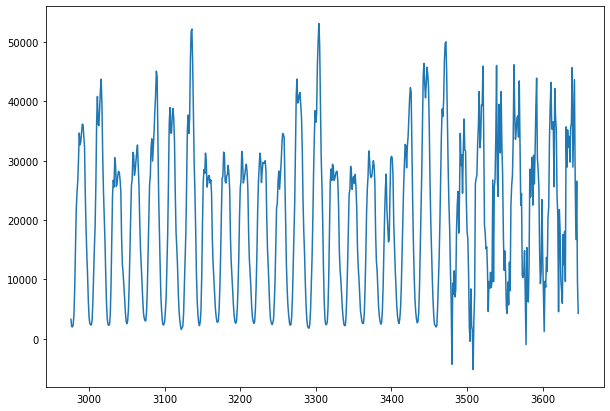

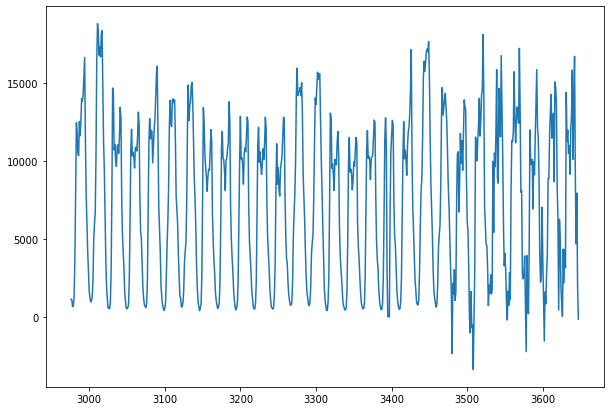

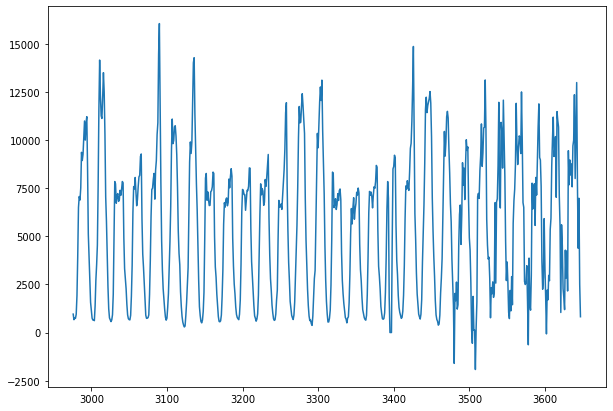

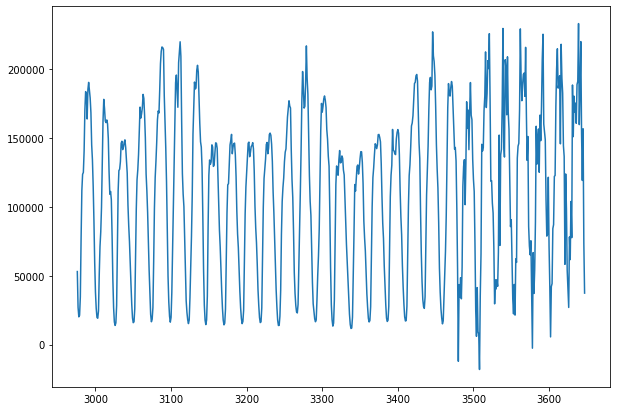

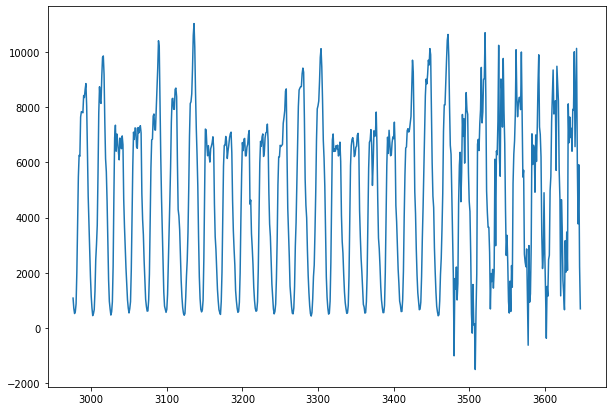

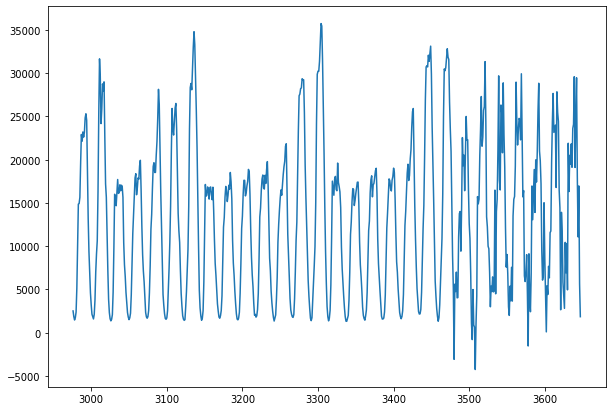

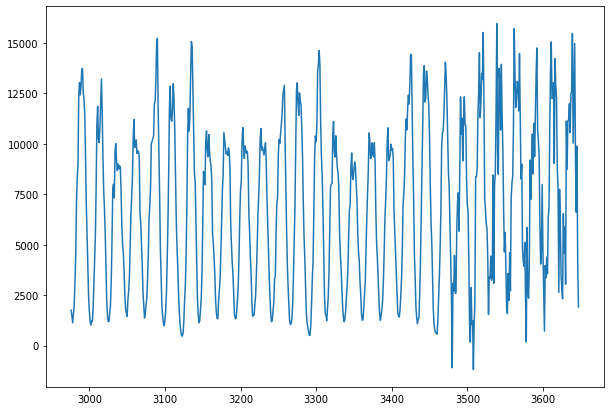

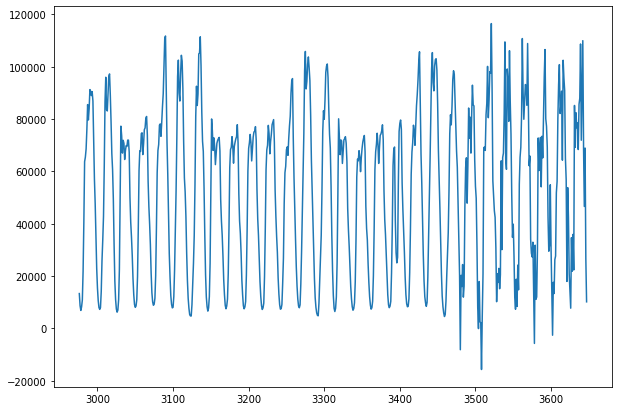

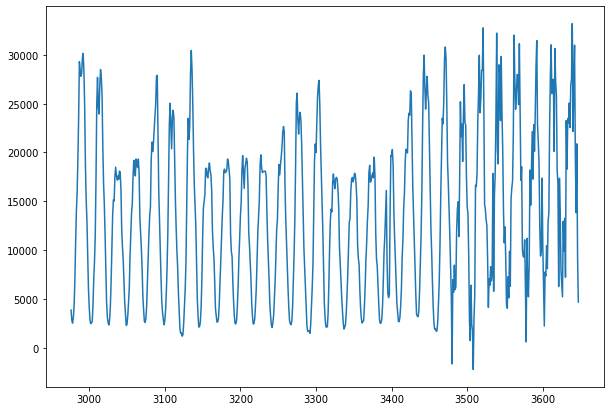

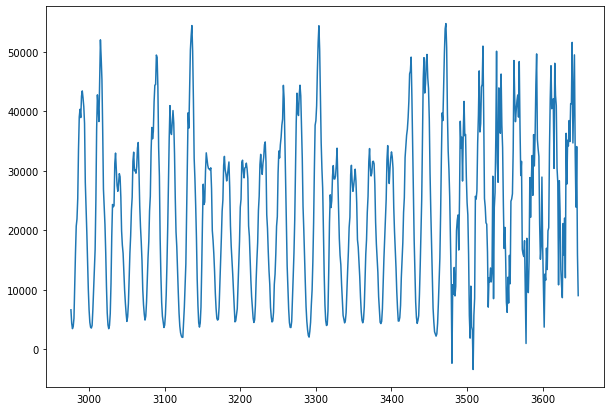

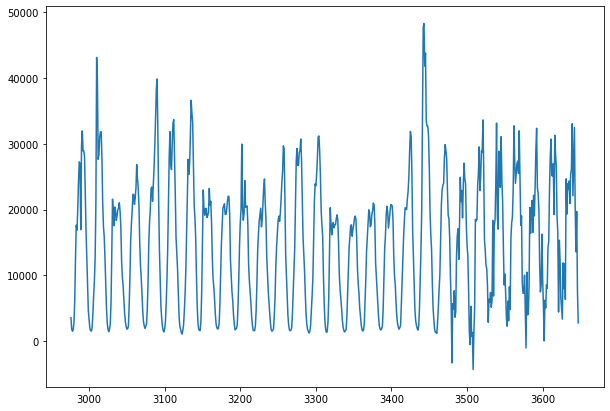

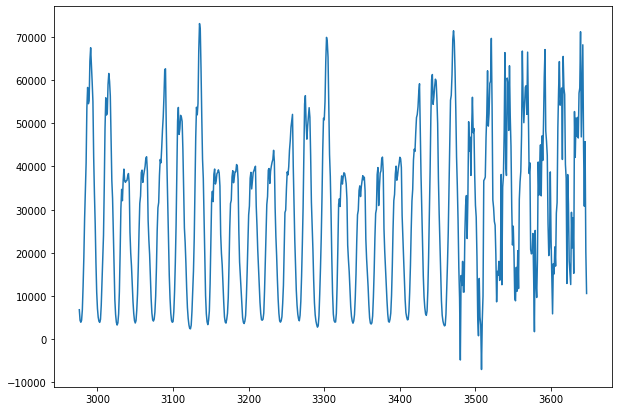

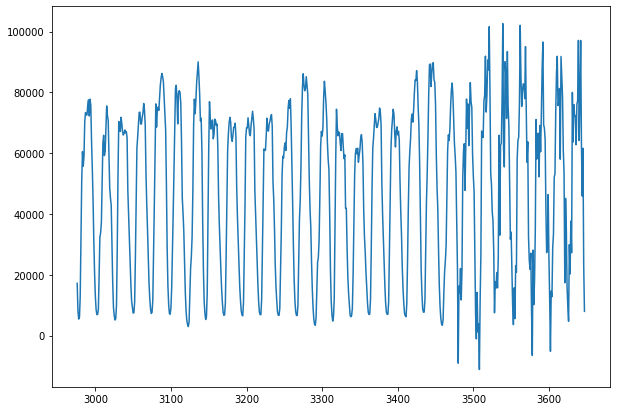

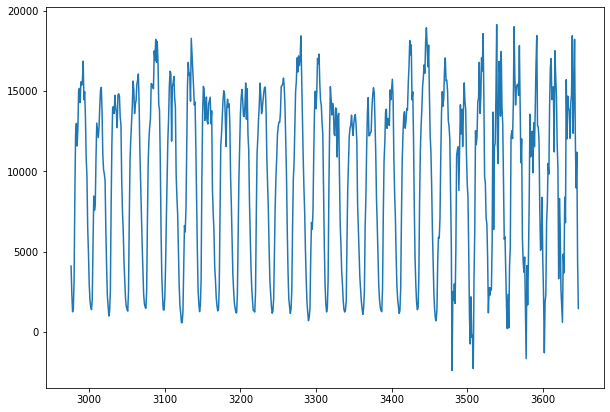

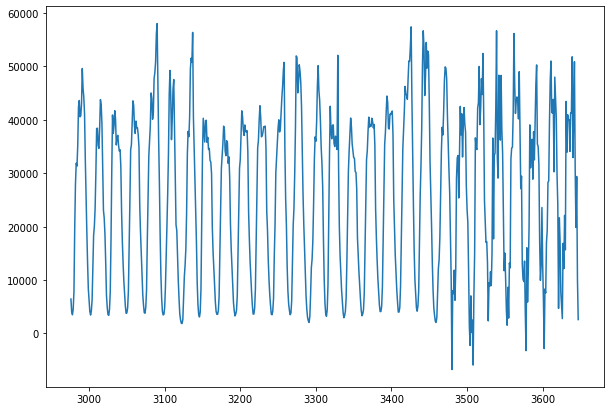

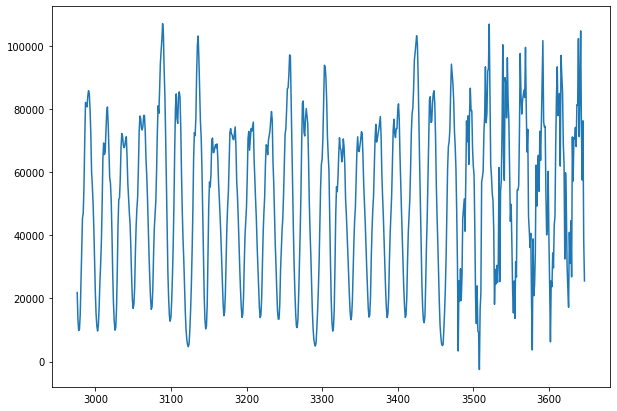

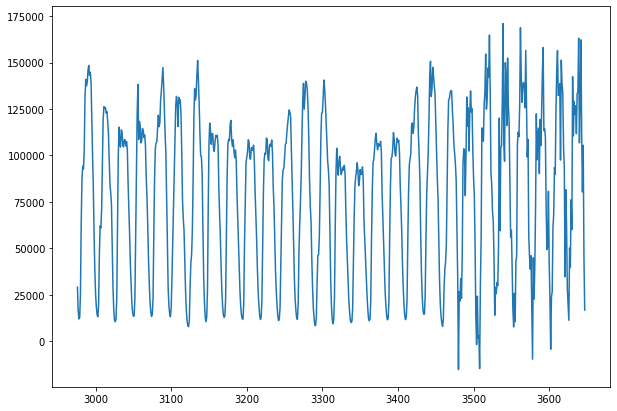

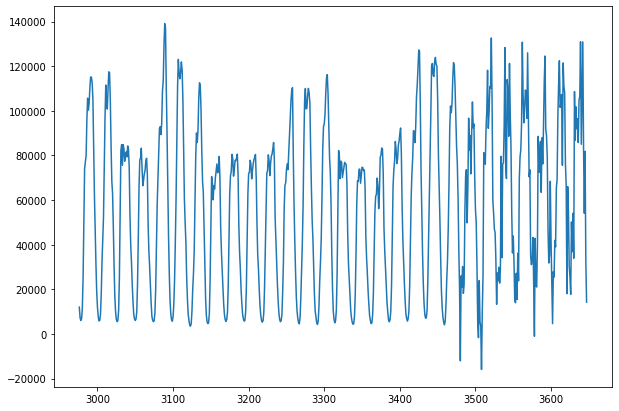

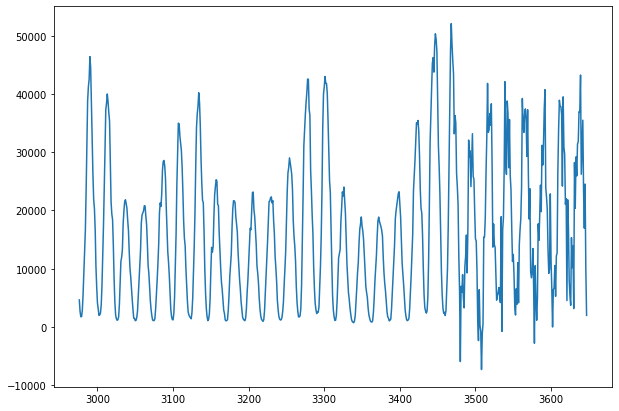

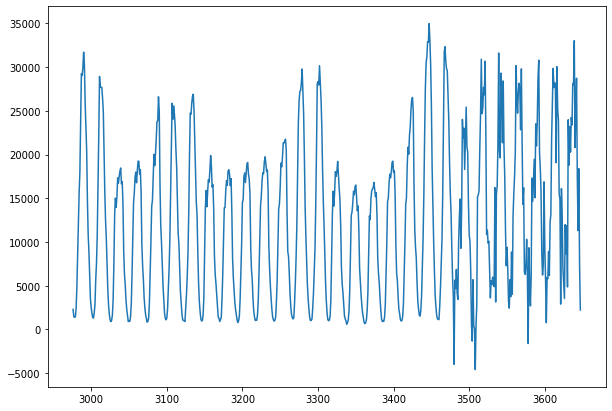

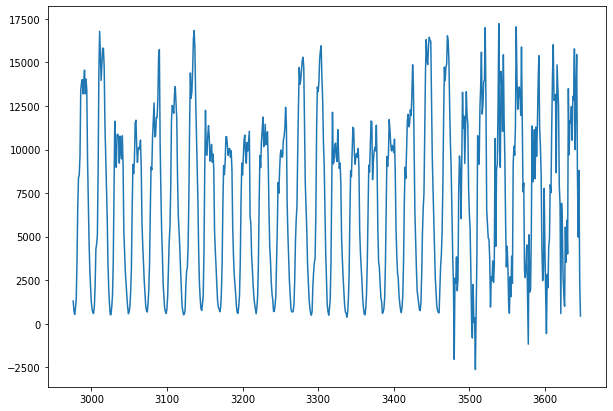

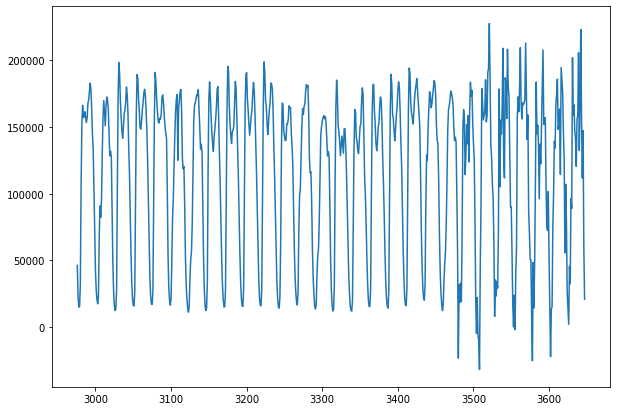

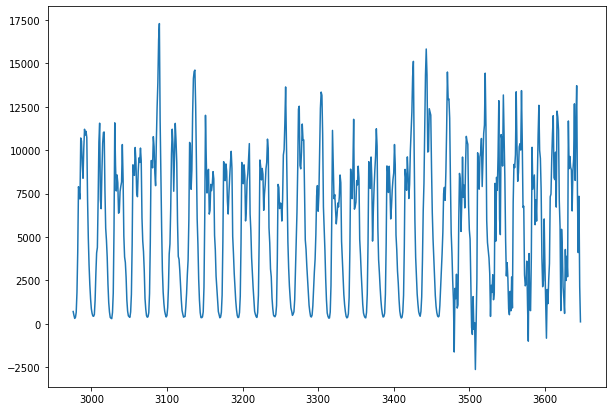

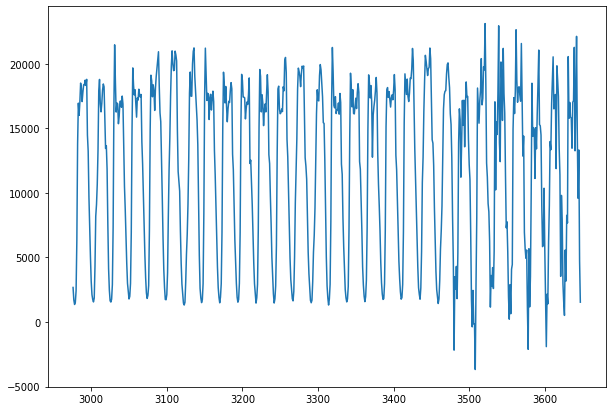

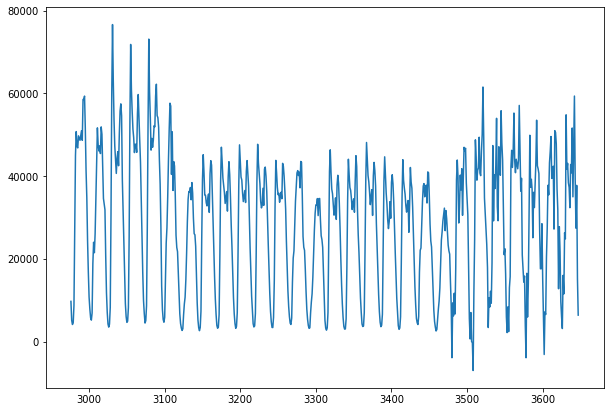

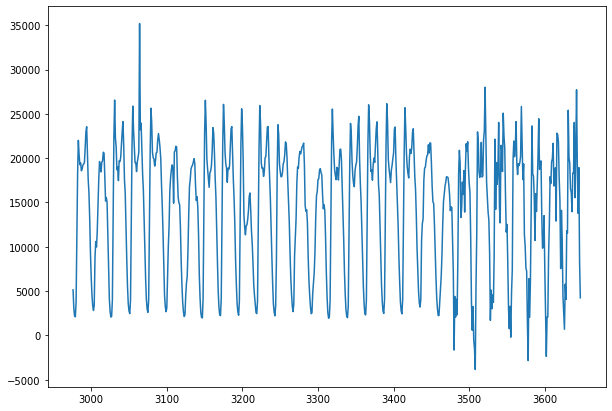

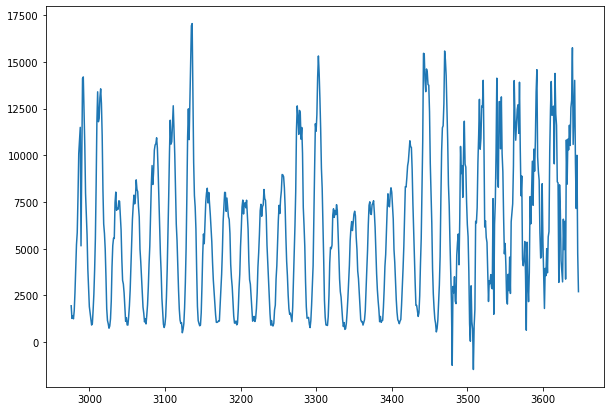

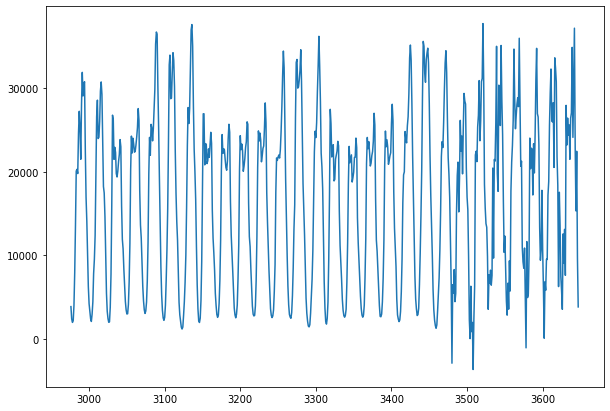

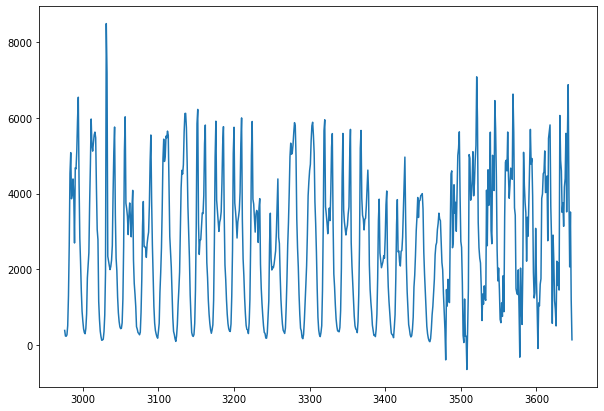

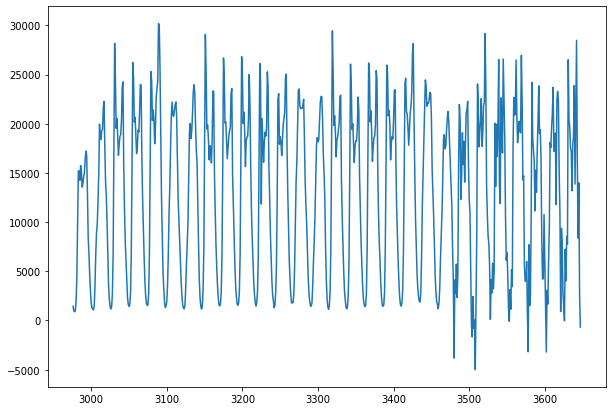

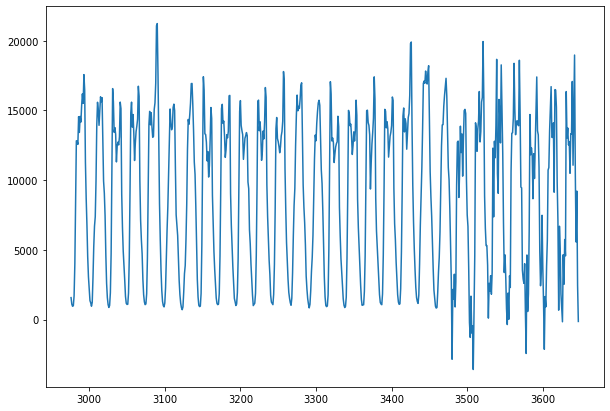

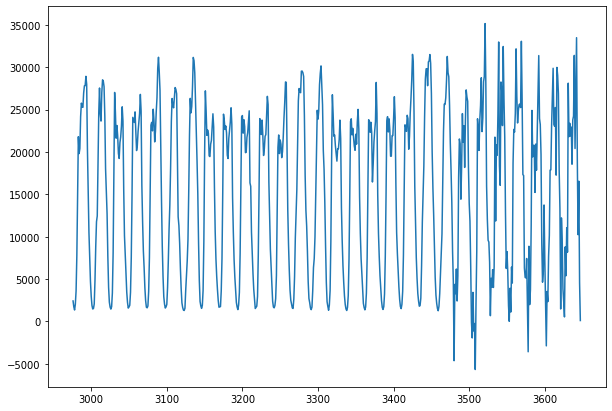

In [238]:
for i in range(len(df_col[2:])) :
    plt.figure(figsize=(10,7))
    plt.plot(df_test.index[-672:],df_test[df_col[i+2]].iloc[-672:])
    plt.show()

In [201]:
temp_set = test_set.copy()

In [162]:
for i in range(35) :
    temp_set[df_col[i+2]] = temp_set[df_col[i+2]] - (temp_set[df_col[i+2]] - temp_set[df_col[i+2]].mean())*0.1

In [202]:
for i in range(35) :
    print(f'Road {df_col[2+i]}')
    print(temp_set[df_col[2+i]].mean(),temp_set[df_col[2+i]].std())
    print(df[df_col[2+i]][-168:].mean(),df[df_col[2+i]][-168:].std())
    print(df[df_col[2+i]][-168*2:-168].mean(),df[df_col[2+i]][-168*2:-168].std())
    print(df[df_col[2+i]][-168*3:-168*2].mean(),df[df_col[2+i]][-168*3:-168*2].std())
    print(df[df_col[2+i]][-168*4:-168*3].mean(),df[df_col[2+i]][-168*4:-168*3].std())
    print(df[df_col[2+i]][-168*5:-168*4].mean(),df[df_col[2+i]][-168*5:-168*4].std())
    print(df[df_col[2+i]][-168*6:-168*5].mean(),df[df_col[2+i]][-168*6:-168*5].std())
    print(df[df_col[2+i]][-168*7:-168*6].mean(),df[df_col[2+i]][-168*7:-168*6].std())

Road 10
265355.2 121076.16
238748.25 119060.2800114471
232663.375 115729.66831705127
242243.64880952382 121771.55895713899
264139.4583333333 133636.26233662645
233155.97023809524 118474.07036527139
224548.70833333334 116419.27424925308
228391.69047619047 117596.0118353521
Road 100
76976.94 42141.836
73083.89285714286 44178.60267563569
70559.53571428571 41964.667440311765
72497.13095238095 44349.410322290016
81473.23809523809 53250.45330230584
67837.11309523809 41458.933658656504
63868.57142857143 38787.98878975486
62965.57142857143 38405.486328941755
Road 101
9655.867 5256.9375
7486.0952380952385 5504.537428544985
7499.428571428572 5141.0501030949
8066.982142857143 5709.491350262397
10526.160714285714 8709.059588390472
7187.2797619047615 5066.980372462213
6887.702380952381 4770.308722932941
6716.755952380952 4676.102436215051
Road 120
23369.797 12024.261
19617.803571428572 13223.802840332548
19345.119047619046 12843.67888135248
20332.839285714286 13681.78928152587
24024.589285714286 18

In [164]:
df_temp = pd.concat([df,temp_set]).reset_index(drop=True)

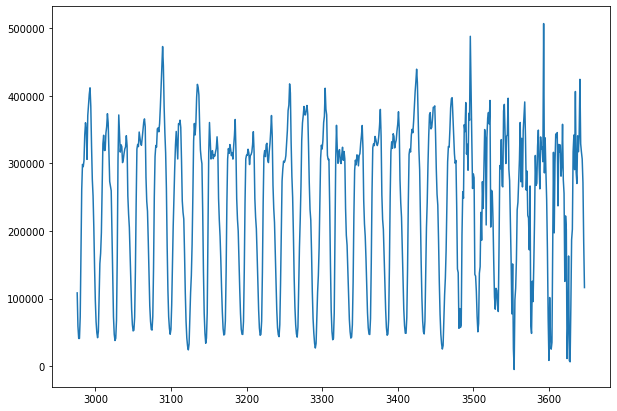

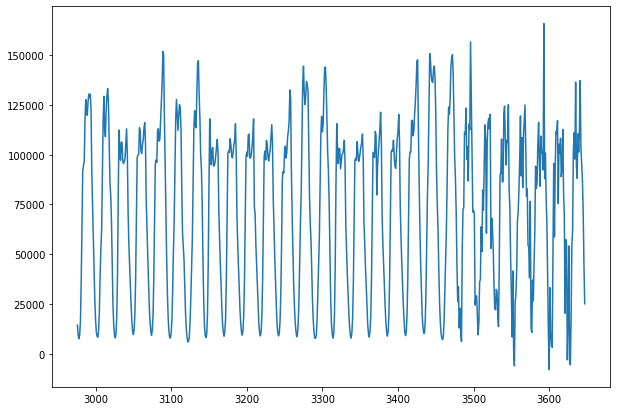

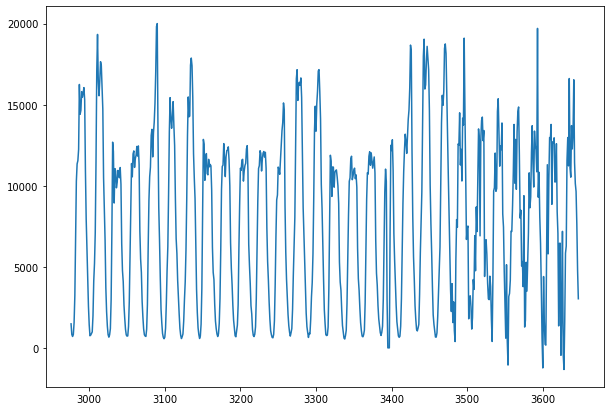

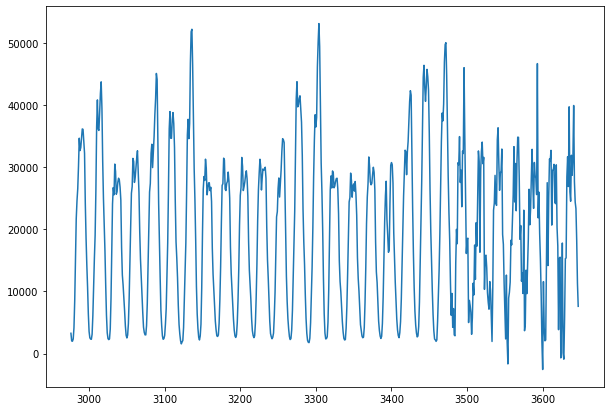

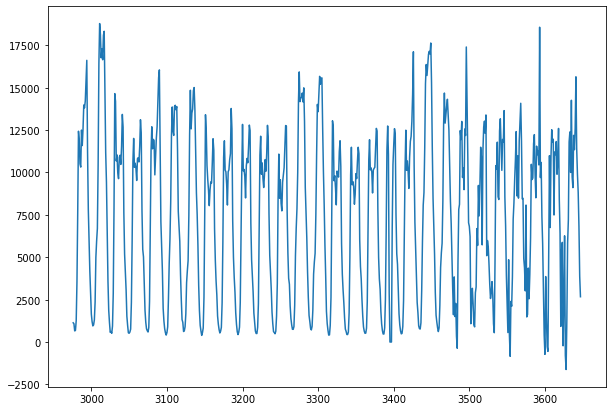

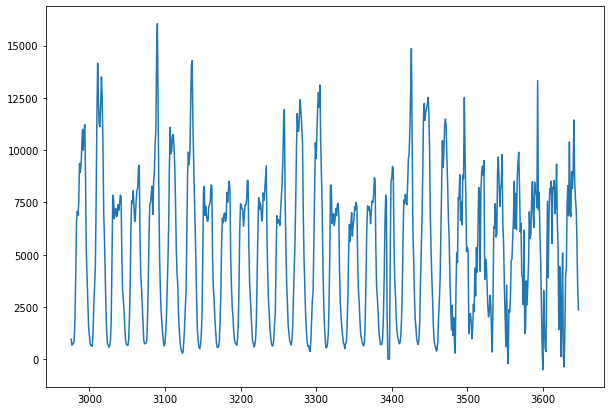

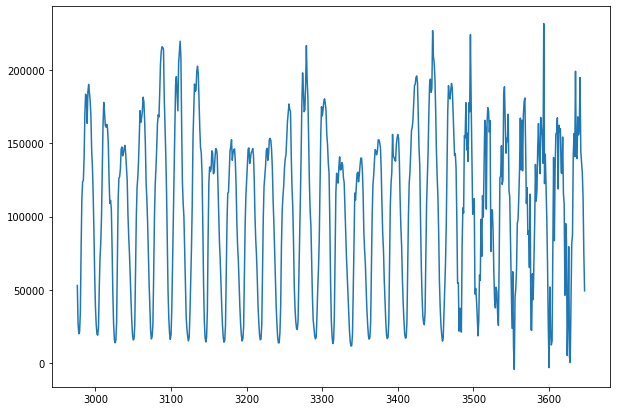

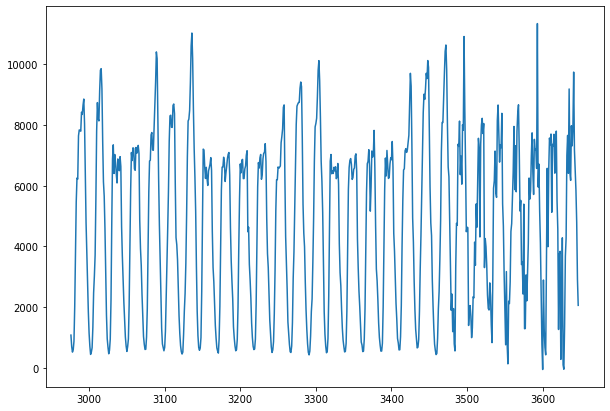

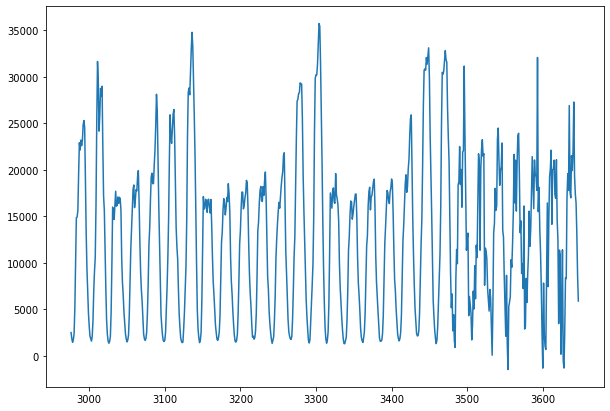

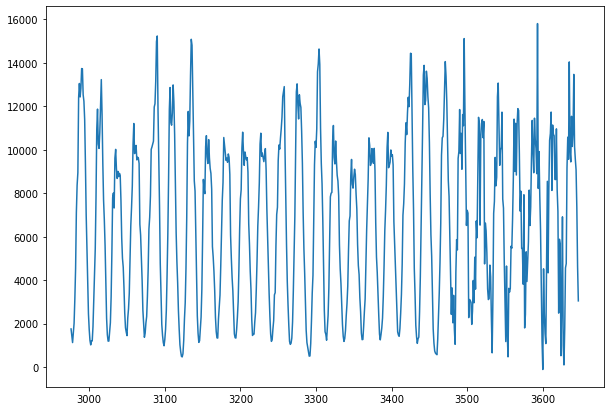

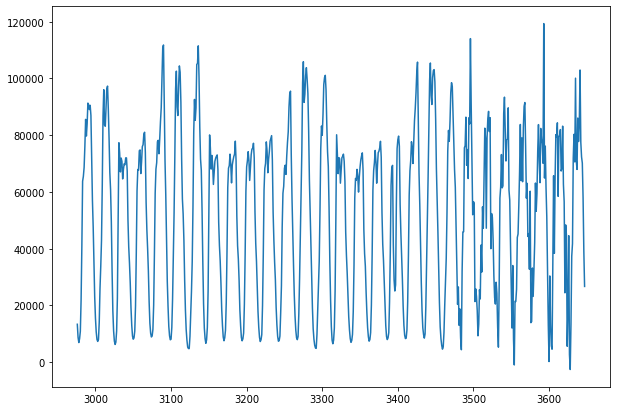

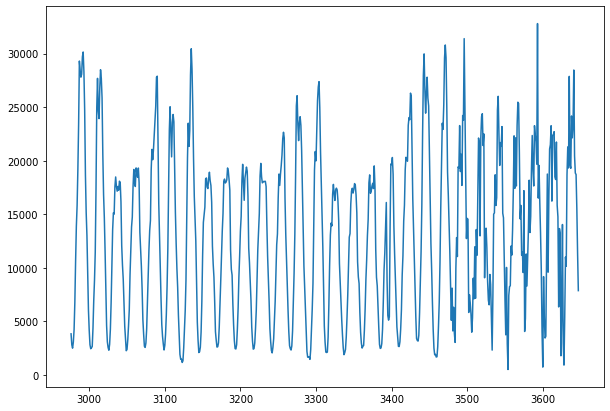

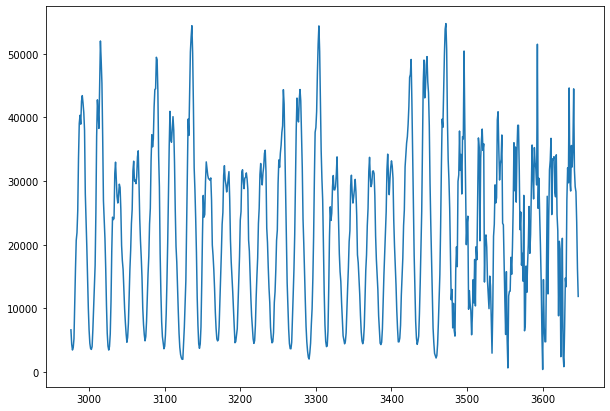

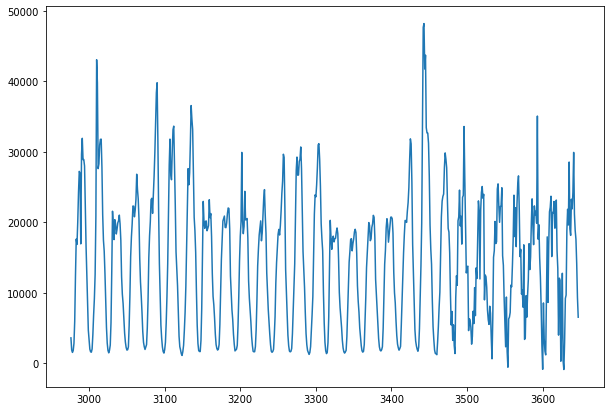

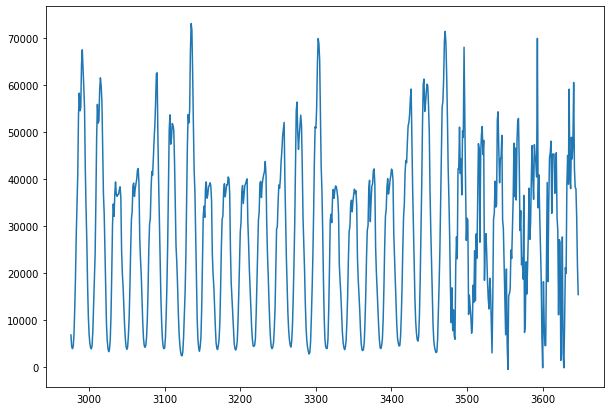

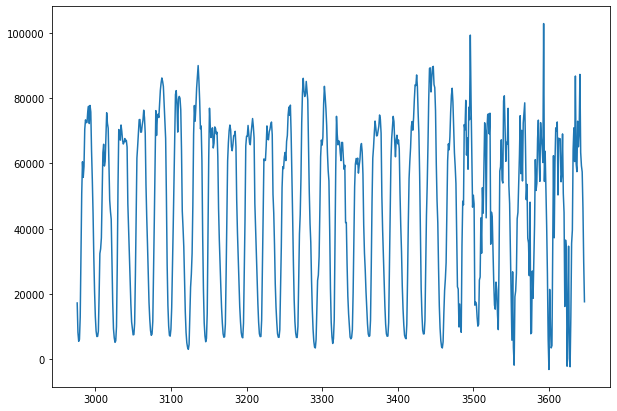

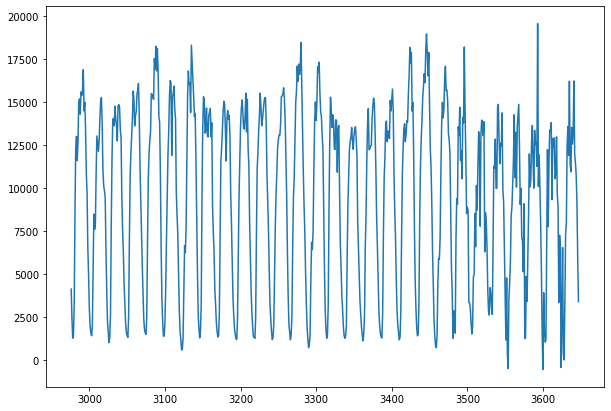

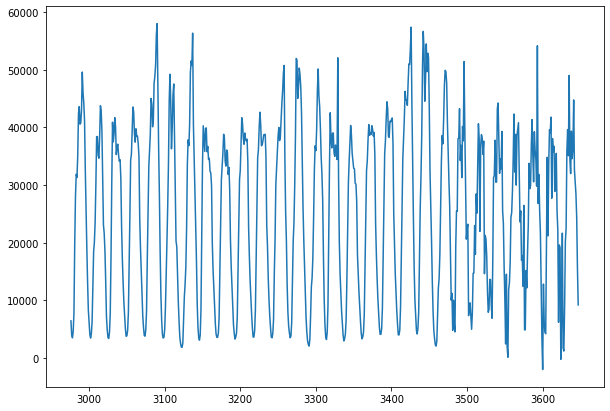

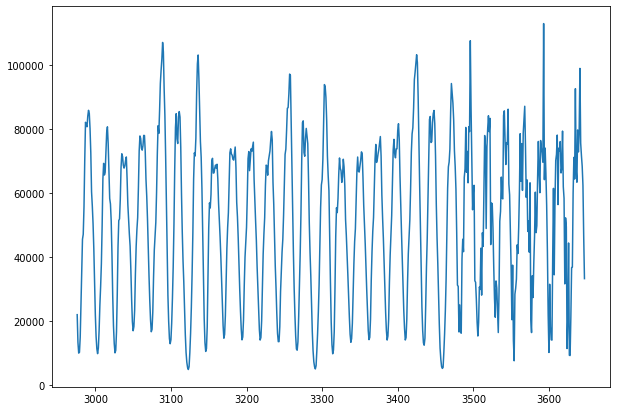

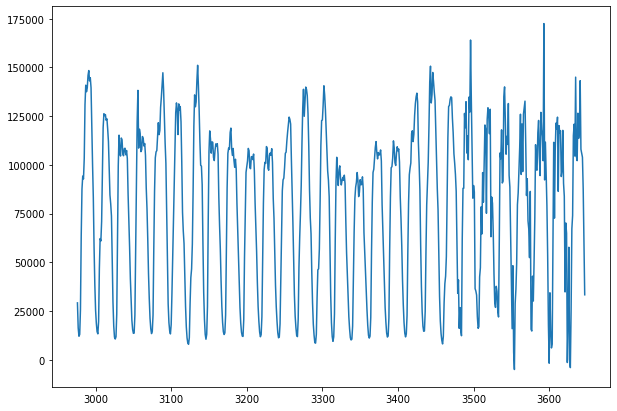

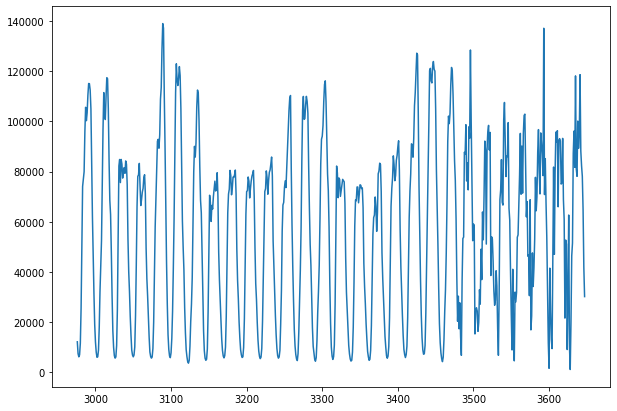

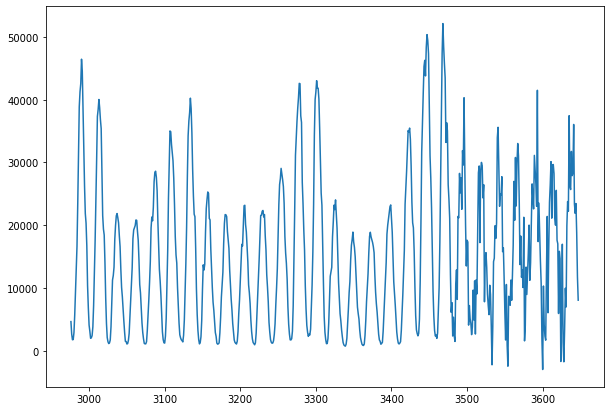

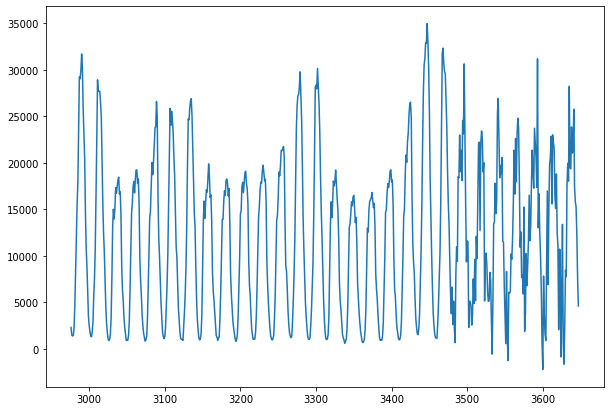

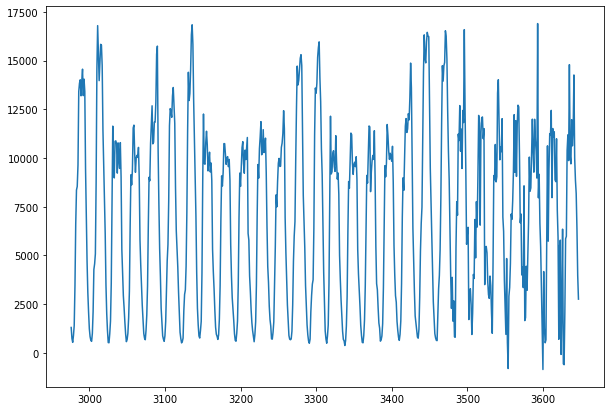

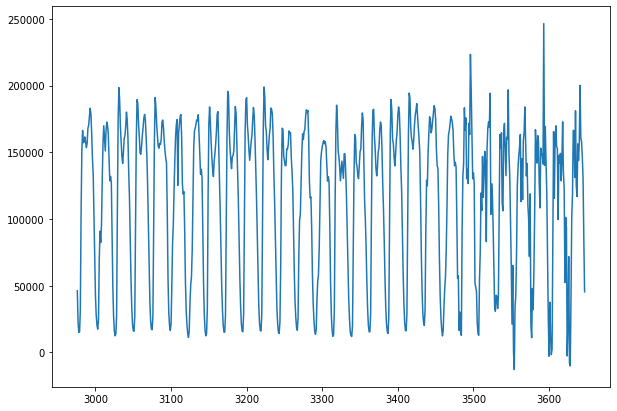

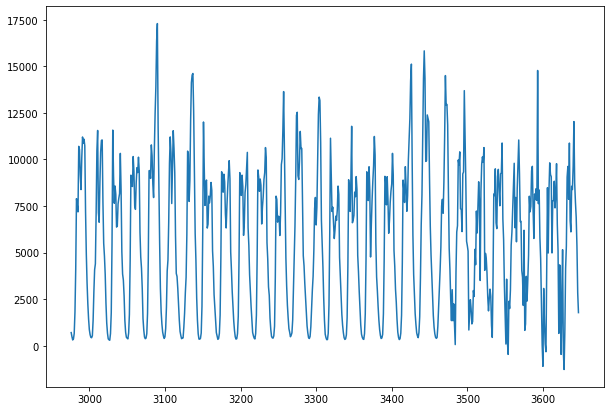

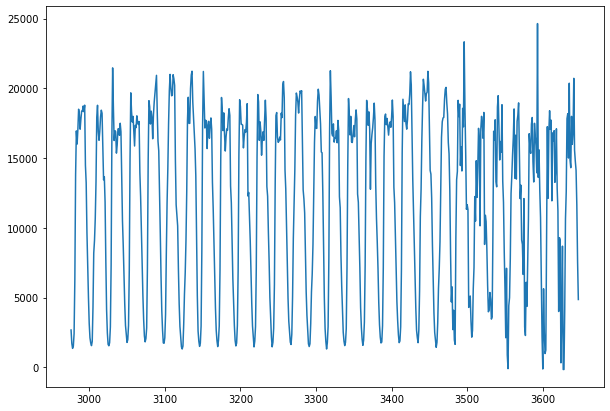

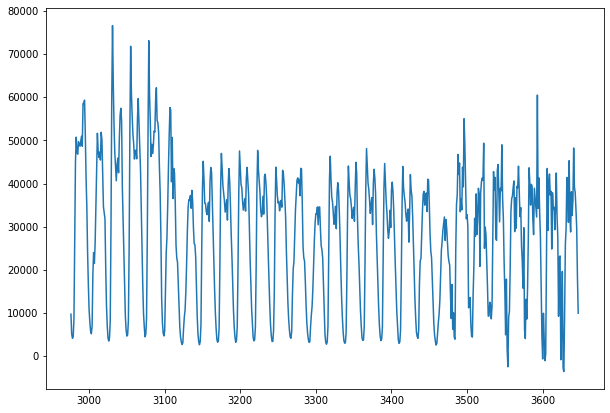

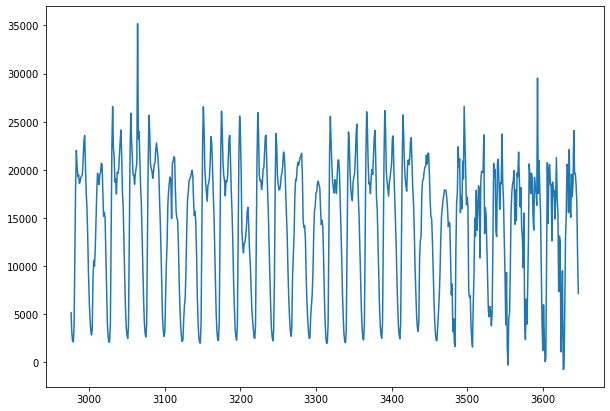

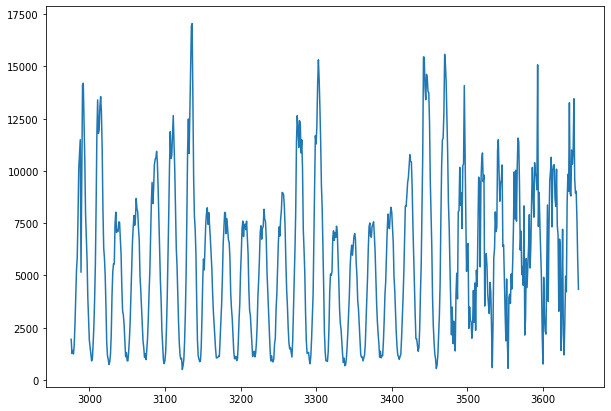

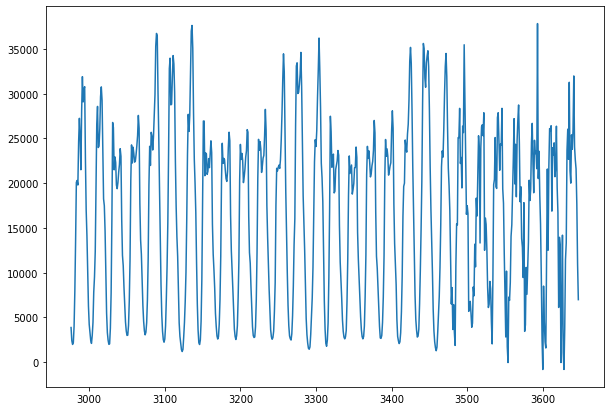

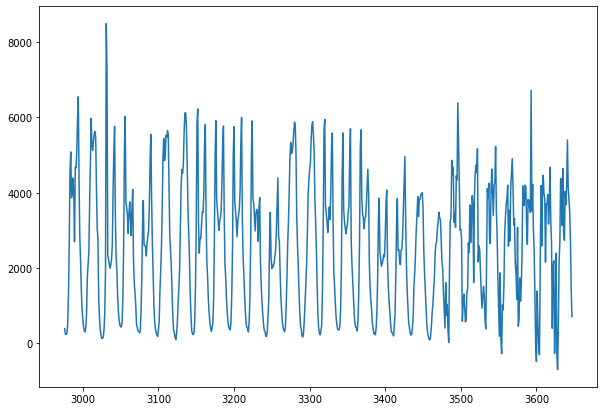

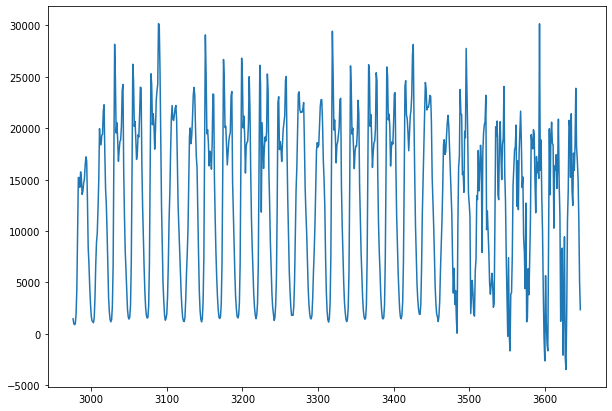

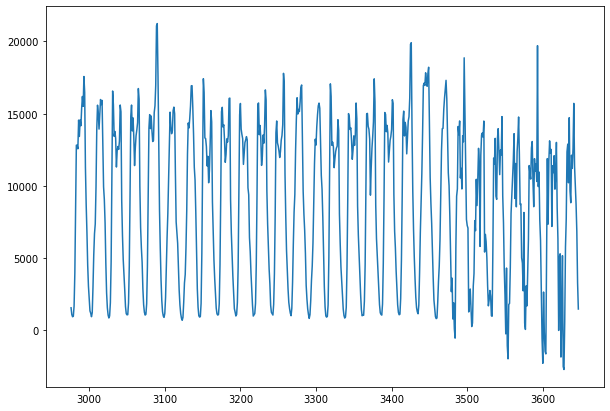

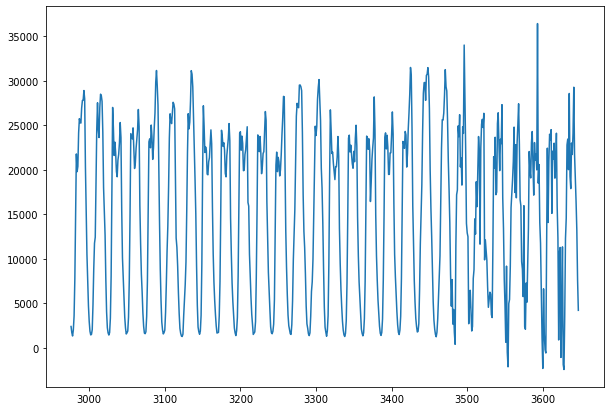

In [165]:
for i in range(len(df_col[2:])) :
    plt.figure(figsize=(10,7))
    plt.plot(df_temp.index[-672:],df_temp[df_col[i+2]].iloc[-672:])
    plt.show()

In [203]:
submission_file_path = os.path.join(data_dir,'sample_submission.csv')
submission_table = pd.read_csv(submission_file_path)

In [204]:
sub_col = submission_table.columns.values

In [168]:
for i in range(len(sub_col[1:])) :
    submission_table[sub_col[i+1]] = temp_set[sub_col[i+1]]

In [169]:
submission_table.to_csv('v201_submission.csv',index=False)

In [205]:
for i in range(len(sub_col[1:])) :
    submission_table[sub_col[i+1]] = test_set[sub_col[i+1]]

In [206]:
submission_table.to_csv('v200_submission.csv',index=False)

In [43]:
submission_table.head()

timestamp             10           100          101           120  \
0  20200525_0   94007.156250  20149.843750  1570.541504   3834.774414   
1  20200525_1  173475.687500  51717.617188  6145.393066  14681.708984   
2  20200525_2   -8941.765625  -7460.718750 -1283.964844  -2753.238281   
3  20200525_3  -59587.140625 -27259.515625 -4121.219727  -8885.685547   
4  20200525_4    2891.812500  -6806.015625 -1908.689453  -2807.460938   

           121          140           150          160           200  ...  \
0  1594.580078  1424.071777  38195.910156  1354.412354   2985.465820  ...   
1  5699.293945  4335.283691  81515.078125  3598.044922  10386.961914  ...   
2 -1380.779785  -660.065430    384.507812  -561.908691  -2073.390625  ...   
3 -3714.728027 -2596.250977 -29159.507812 -1996.179199  -6456.494141  ...   
4 -1885.562012 -1340.165527   2398.523438  -805.200684  -2377.290039  ...   

          1020         1040          1100          1200         1510  \
0   946.685547  3178.971191   9041.197266   6356.314453  1719.013672   
1  4368.864258  8059.537109  19819.347656  10750.865234  4929.825195   
2 -1064.442871  -694.420898  -3868.029297   -733.430664  -309.254883   
3 -2922.432129 -3348.442383  -9711.859375  -3564.121094 -2505.842773   
4 -1595.864746  -586.076172   1263.042969    964.704102  -966.259277   

           2510         3000         4510         5510          6000  
0   4885.713867   723.683228  2654.126953  2386.081543   2725.327148  
1  12484.518555  2247.956787  9509.210938  6681.404297  10662.132812  
2  -1032.367188  -473.757568 -2169.594727 -1082.088867  -2086.837891  
3  -5834.084961 -1559.841309 -5473.761719 -3332.212891  -5832.542969  
4  -1659.508789  -893.871826 -2052.272461  -972.342773  -1709.270508  

[5 rows x 36 columns]